# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


# Exploring the data

In [3]:
churn.shape

(46206, 21)

In [4]:
# Statistical summary
churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,28416.000000,28416.000000,28416.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029,0.014640,0.191125,0.007038
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041,0.120108,0.393194,0.083600
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000,0.000000,0.000000,0.000000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000,0.000000,0.000000,0.000000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000,0.000000,0.000000,0.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000,1.000000,1.000000,1.000000


In [5]:
# Values in CHURN_IND column
set(churn['CHURN_IND'])

{0, 1}

In [6]:
# Check how many of each values there are in the CHURN_IND column 
print("No of CHURN_IND - 1: ", churn[churn['CHURN_IND'] == 0].shape[0])
print("No of CHURN_IND - 2: ", churn[churn['CHURN_IND'] == 1].shape[0])

No of CHURN_IND - 1:  28416
No of CHURN_IND - 2:  17790


# Dropping NaN rows

In [7]:
# Check NaN values
churn.isna().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64

In [8]:
# Drop NaN values only from listed columns
churn = churn.dropna(subset=['AGE', 'COUNTRY_METRO_REGION', 'STATE'])
churn.shape

(46129, 21)

In [9]:
# Check rows has been dropped
churn.isna().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                 0
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                0
STATE                               0
RECON_SMS_NEXT_MTH              17763
RECON_TELE_NEXT_MTH             17763
RECON_EMAIL_NEXT_MTH            17763
dtype: int64

In [10]:
# Dropping categorical value columns
churn.drop(['CFU', 'BYO_PLAN_STATUS', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE'], axis = 1, inplace = True)

We can either drop or create dummy values for categorical values. In this case, we will be dropping all categorical value columns for an easier analysis. 

# Visual representation of our prediction column data

<AxesSubplot:xlabel='CHURN_IND', ylabel='count'>

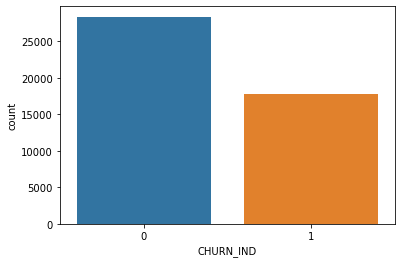

In [11]:
# Visual representation of each value in CHURN_IND column
sns.countplot(x='CHURN_IND', data=churn)

# Build the Logistic Regression model

In [12]:
# Split the data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(churn, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(36903, 15)
(9226, 15)


In [13]:
# Build the Logistic Regression model
X_train = train.drop(['CHURN_IND', 'CUST_ID', 'RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND', 'CUST_ID', 'RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1)
y_test = test['CHURN_IND']

print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (36903, 10)
y_train shape:  (36903,)
x_test shape:  (9226, 10)
y_test shape:  (9226,)


We want to predict the value for the <b>CHURN_IND</b> column, so we will have this as the y value for prediction. The X values are the dependant variables that can be changed. We will be dropping the prediction and other unnecessary columns to build the model.

# Training model

In [14]:
# Logistic Regression fit
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [15]:
# Do predictions on train set
y_predict_train = model.predict(X_train)

We will be using the training model first to predict the <b>CHURN_IND</b> column.

# Evaluation

In [16]:
# Evaluate the performance of the training model
print("Accuracy score of training set: ", accuracy_score(y_train, y_predict_train))

Accuracy score of training set:  0.7106197328130505


The accuracy score for predicting the <b>CHURN_IND</b> value using the training model is at <b>0.7106197328130505</b>. We will compare this value with the prediction value.

In [17]:
# Confusion matrix
print("Confusion matrix on train set: ")
confusion_matrix(y_train, y_predict_train) 

Confusion matrix on train set: 


array([[18614,  4097],
       [ 6582,  7610]], dtype=int64)

# Feature Selection

In [18]:
# Recursive feature eliminiation 
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(estimator=lr_model, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)

During the testing and analysis stage, the number of features <b>(n_features_to_select)</b> was changed and tested with every value from 1 to 10, with the best number updated for final version. For the training model, the final results show that when all 10 features are selected, it produces the best result.

In [19]:
# Predict the accuracy score 
y_train_predict = rfe.predict(X_train)
print("Accuracy score on training set: ", accuracy_score(y_train, y_train_predict))

Accuracy score on training set:  0.7106197328130505


This prediction score differed whilst testing different number of features and is updated to the final version of 10.

In [20]:
# Datafrane for training data after dropping columns
X_train.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND
INDEX,,,,,,,,,,
17987,49,1,54.0,49,17.27,3,0,12,12,17.27
40322,9,1,34.0,9,40.90,9,0,0,0,80.57
36074,41,3,50.0,41,72.72,0,24,24,24,82.39
27215,89,1,34.0,89,17.27,4,0,0,0,17.27
7788,83,1,55.0,83,17.27,3,0,12,12,17.27


In [21]:
# Ranking columns for best feature selection
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000


In this case for training model, the rank for every column will be 1st due to the results stating that every feauture column must be selected to produce the best results.

In [22]:
# To increment number of features, one at each time
acc_scores = []
for i in range(1, 11):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # Training model
    rfe.fit(X_train, y_train)
    # Predicting on train set
    y_pred = rfe.predict(X_train)
    acc_score = accuracy_score(y_train, y_pred)

    print("Acc on train set using", i, "features: ", acc_score)
    # Append to the list
    acc_scores.append(acc_score)

Acc on train set using 1 features:  0.6363439286778853
Acc on train set using 2 features:  0.6626832506842262
Acc on train set using 3 features:  0.6643091347586917
Acc on train set using 4 features:  0.6640652521475219
Acc on train set using 5 features:  0.7046310598054358
Acc on train set using 6 features:  0.704847844348698
Acc on train set using 7 features:  0.7078557298864591
Acc on train set using 8 features:  0.7078557298864591
Acc on train set using 9 features:  0.7101861637265263
Acc on train set using 10 features:  0.7106197328130505


As seen from the accuracy the training model produces with different number of features selected above, there is an obvious steady increasing trend as more feature columns are selected. Higher accuracy scores produces better results.

E:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
E:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
E:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
E:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (re

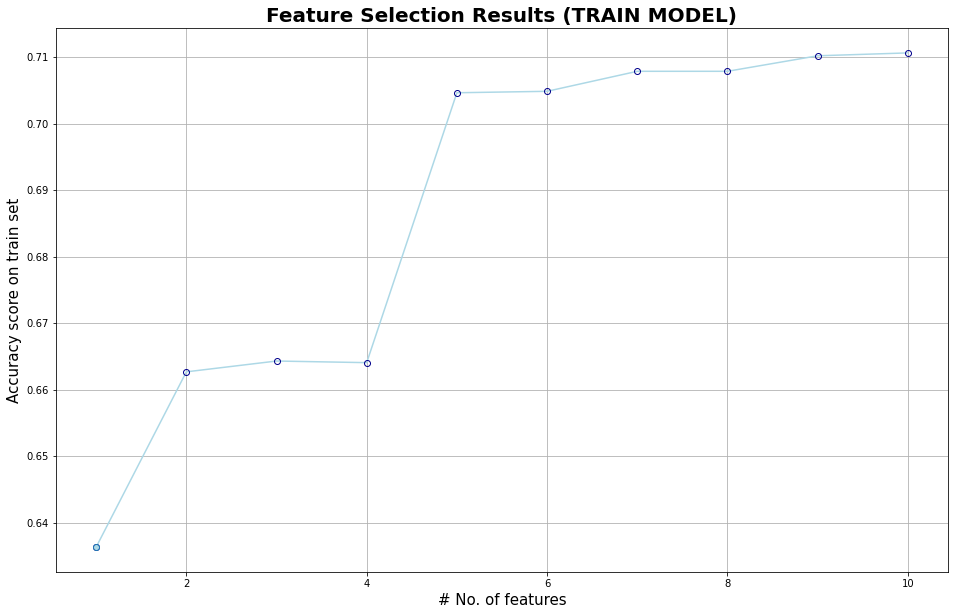

In [23]:
# Estimating accuracy score on train set using RFE by using different number of features
estimator = LogisticRegression(solver='lbfgs', max_iter=1000)
acc_scores = []
for i in range(1, 11):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_train)
    acc_score = accuracy_score(y_train, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1
 
plt.figure(figsize=(16, 10))
plt.title('Feature Selection Results (TRAIN MODEL)', fontsize=20, fontweight='bold')
plt.xlabel('# No. of features', fontsize=15)
plt.ylabel('Accuracy score on train set', fontsize=15)
plt.plot(range(1, 11), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'darkblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')
plt.grid()   
plt.show()

# Analysis

As seen from the graph above, it is a perfect visual representation of the accuracy scores on the training model when we use the feauture selection and the RFE method. There is an obvious relationship when <b>2 ~ 4</b> features are selected as accuracy scores produce very similar results around <b>0.66 ~ 0.67</b>. However, <b>when 5 or more features</b> are selected, there is a noticeable increase in the accuracy score to <b>above 0.70</b>. In conclusion, using the results from the training model, we can say that the accuracy score increases as the <b>n_features_to_select</b> increases in the RFE method.

# Testing model

In [24]:
# Logistic Regression fit
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_test, y_test)

LogisticRegression(max_iter=1000)

In [25]:
# Do predictions on train set
y_predict_test = model.predict(X_test)

We will now use the test model first to predict the <b>CHURN_IND</b> column.

In [26]:
# Evaluate the performance of the training model
print("Accuracy score of testing set: ", accuracy_score(y_test, y_predict_test))

Accuracy score of testing set:  0.7030132234988077


The accuracy score for predicting the <b>CHURN_IND</b> value using the training model is at <b>0.7106197328130505</b>. We will compare this value with the prediction value.

In [27]:
# Confusion matrix
print("Confusion matrix on test set: ")
confusion_matrix(y_test, y_predict_test) 

Confusion matrix on test set: 


array([[4575, 1080],
       [1660, 1911]], dtype=int64)

In [28]:
# Recursive feature eliminiation 
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(estimator=lr_model, n_features_to_select=6, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=6)

During the testing and analysis stage, the number of features <b>(n_features_to_select)</b> was changed and tested with every value from 1 to 10, with the best number updated for final version. For the training model, the final results show that when all 6 features are selected, it produces the best result.

In [29]:
# Predict the accuracy score 
y_test_predict = rfe.predict(X_test)
print("Accuracy score on test set: ", accuracy_score(y_test, y_test_predict))

Accuracy score on test set:  0.7040971168437026


This prediction score differed whilst testing different number of features and is updated to the final version of 10.

In [30]:
# Datafrane for training data after dropping columns
X_test.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND
INDEX,,,,,,,,,,
7121,3,1,70.0,3,27.27,3,0,0,0,58.96
43149,54,2,46.0,54,36.36,9,15,24,24,48.17
39073,1,3,41.0,1,27.27,1,0,0,0,18.17
5664,4,1,32.0,4,72.72,4,20,24,0,261.06
17660,52,1,41.0,52,54.54,5,19,24,24,89.06


In [31]:
# Ranking columns for best feature selection
for i in range(X_test.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 3.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 4.000
Column: 4, Selected False, Rank: 2.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 5.000
Column: 9, Selected True, Rank: 1.000


In this case for testing model, the LogisticRegression model using feature selection produces the best results when 6 features are selected. The best 6 features are ranked 1 as seen above. They are columns <b>ACCOUNT_TENURE, AGE, PLAN_TENURE, MONTHS_OF_CONTRACT_REMAINING, LAST_FX_CONTRACT_DURATION and MONTHLY_SPEND</b>

In [32]:
# to increment number of features, one at each time
acc_scores = []
for i in range(1, 11):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.6404725774983742
Acc on test set using 2 features:  0.6561890309993497
Acc on test set using 3 features:  0.6584652070236289
Acc on test set using 4 features:  0.6606329937134185
Acc on test set using 5 features:  0.7021461088228919
Acc on test set using 6 features:  0.7040971168437026
Acc on test set using 7 features:  0.7016041621504444
Acc on test set using 8 features:  0.701062215477997
Acc on test set using 9 features:  0.703988727509213
Acc on test set using 10 features:  0.7037719488402341


As seen from the accuracy the testing model produces with different number of features selected above, results show some similarity to the results from training model. The best result is produced when 6 features are selected, however there is a similar continuous increase in the accuracy scores when features selection also increases. 

E:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
E:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
E:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
E:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (re

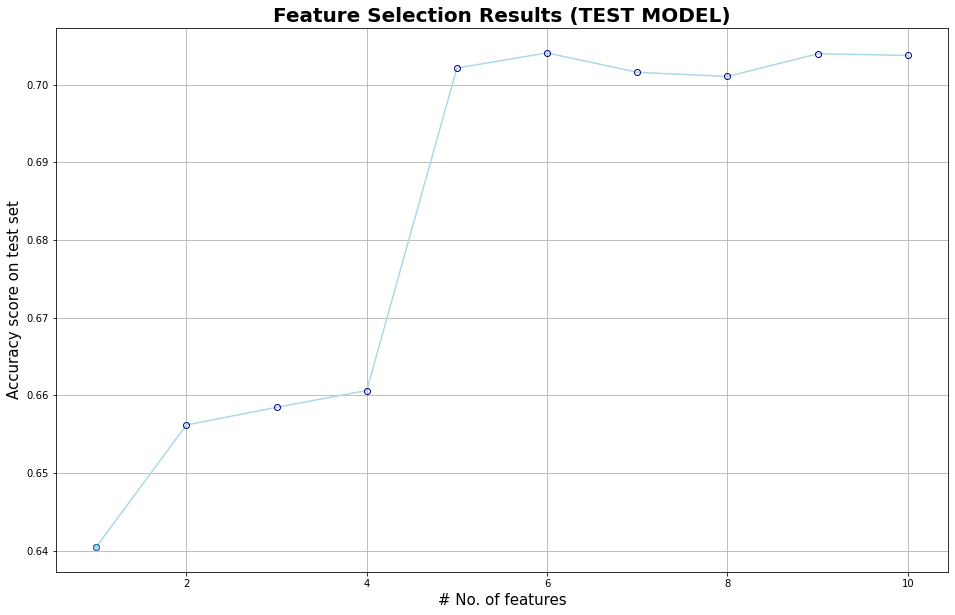

In [34]:
# Estimating accuracy score on test set using RFE by using different number of features
estimator = LogisticRegression(solver='lbfgs', max_iter=1000)
acc_scores = []
for i in range(1, 11):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1
 
plt.figure(figsize=(16, 10))
plt.title('Feature Selection Results (TEST MODEL)', fontsize=20, fontweight='bold')
plt.xlabel('# No. of features', fontsize=15)
plt.ylabel('Accuracy score on test set', fontsize=15)
plt.plot(range(1, 11), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'darkblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')
plt.grid()   
plt.show()

# Analysis

As seen from the graph above, it is a perfect visual representation of the accuracy scores on the testing model when we use the feauture selection and the RFE method. There is a slight increasing trend from selection of <b>2 ~ 4</b> features, as accuracy scores are seen to be increasing slightly. However, <b>when 5 or more features</b> are selected, there is a noticeable increase in the accuracy score to <b>above 0.70</b>, which is similar to the training model. In conclusion, using the results from the testing model, we can say that the accuracy score increases as the <b>n_features_to_select</b> increases in the RFE method, however as the values for the training model is more accurate, the training data will be a more reliable analysis in the case of predicting the CHURN_IND values.